In [72]:
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [73]:

# 1. RoboGrid3DEnvironment Class
class RoboGrid3DEnvironment:
    def __init__(self, grid_size, start, goals, obstacles):
        self.grid_size = grid_size  # Grid dimensions (x, y, z)
        self.start = start          # Start position of the robot (x, y, z)
        self.goals = goals          # List of goal positions [(x, y, z), (x, y, z), ...]
        self.obstacles = obstacles  # List of obstacle positions [(x, y, z), (x, y, z), ...]
        self.state = self.start     # Current state (position)
        self.actions = ['up', 'down', 'left', 'right', 'forward', 'backward']  # Possible actions

    def reset(self):
        """Reset the environment to a random state in 3D."""
        while True:
            random_x = random.randint(0, self.grid_size[0] - 1)
            random_y = random.randint(0, self.grid_size[1] - 1)
            random_z = random.randint(0, self.grid_size[2] - 1)
            #random_state = (random_x, random_y, random_z)
            random_state = (0, 0, 0)
            if random_state not in self.obstacles:  # Ensure the random state is not an obstacle
                self.state = random_state
                break
        return self.state

    def step(self, action):
        """Take a step in the 3D environment and return next state, reward, and done flag."""
        x, y, z = self.state
        if action == 'up' and z < self.grid_size[2] - 1:
            z += 1
        elif action == 'down' and z > 0:
            z -= 1
        elif action == 'left' and y > 0:
            y -= 1
        elif action == 'right' and y < self.grid_size[1] - 1:
            y += 1
        elif action == 'forward' and x < self.grid_size[0] - 1:
            x += 1
        elif action == 'backward' and x > 0:
            x -= 1

        next_state = (x, y, z)
        self.state = next_state

        # If the robot reaches any of the goal states, give a reward of +1 and end the episode
        if next_state in self.goals:
            reward = 1
            done = True
        # If the robot hits an obstacle, give a reward of -1 and end the episode
        elif next_state in self.obstacles:
            reward = -1
            done = True
        # Otherwise, give a small negative reward (penalty) for each step
        else:
            reward = -0.01
            done = False

        return next_state, reward, done


In [74]:
# 2. Q-learning in 3D
def initialize_q_table_3d(grid_size, actions):
    """Initialize the Q-table with zeros for all states and actions in a 3D grid."""
    return np.zeros((grid_size[0], grid_size[1], grid_size[2], len(actions)))

def choose_action_3d(state, q_table, epsilon, actions):
    """Epsilon-greedy action selection in a 3D grid."""
    if random.uniform(0, 1) < epsilon:
        # Explore: Choose a random action
        return random.choice(actions)
    else:
        # Exploit: Choose the action with the highest Q-value for the current state
        state_action_values = q_table[state[0], state[1], state[2], :]
        return actions[np.argmax(state_action_values)]


In [75]:
def q_learning_3d(env, episodes, alpha, gamma, epsilon):
    """Q-learning algorithm for the robo-grid environment in 3D."""
    q_table = initialize_q_table_3d(env.grid_size, env.actions)
    rewards_per_episode = []

    for episode in range(episodes):
        state = env.reset()
        total_rewards = 0
        done = False

        while not done:
            action = choose_action_3d(state, q_table, epsilon, env.actions)
            next_state, reward, done = env.step(action)
            
            # Update Q-value using the Q-learning update rule
            action_index = env.actions.index(action)
            next_max = np.max(q_table[next_state[0], next_state[1], next_state[2], :])
            q_table[state[0], state[1], state[2], action_index] = q_table[state[0], state[1], state[2], action_index] + alpha * (
                reward + gamma * next_max - q_table[state[0], state[1], state[2], action_index]
            )

            state = next_state
            total_rewards += reward

        rewards_per_episode.append(total_rewards)

    return q_table, rewards_per_episode


In [76]:
# 3. Visualization in 3D
def plot_optimal_policy_3d(q_table, env):
    """Visualize the optimal policy as arrows in the 3D grid."""
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Action symbols for 3D: 'up', 'down', 'left', 'right', 'forward', 'backward'
    action_vectors = {
        'up': (0, 0, 1),
        'down': (0, 0, -1),
        'left': (0, -1, 0),
        'right': (0, 1, 0),
        'forward': (1, 0, 0),
        'backward': (-1, 0, 0)
    }

    for x in range(env.grid_size[0]):
        for y in range(env.grid_size[1]):
            for z in range(env.grid_size[2]):
                if (x, y, z) not in env.obstacles:
                    action_index = np.argmax(q_table[x, y, z, :])
                    best_action = env.actions[action_index]
                    ax.quiver(x, y, z, *action_vectors[best_action], length=0.5, color='b')

    # Plotting goals and obstacles
    for goal in env.goals:
        ax.scatter(goal[0], goal[1], goal[2], color='g', marker='o', s=100, label='Goal')
    
    for obstacle in env.obstacles:
        ax.scatter(obstacle[0], obstacle[1], obstacle[2], color='r', marker='x', s=100, label='Obstacle')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title('Optimal Policy in 3D Robo Grid')
    plt.show()

# Running the Q-learning Algorithm in 3D and Visualizing the Path


In [77]:
# Define the grid environment with multiple goals in 3D
grid_size = (5, 5, 5)
start = (0, 0, 0)
goals = [(4, 4, 3)]#, (0, 4, 4)]  # Two goal states in 3D
obstacles = [(2, 2, 2), (3, 2, 3)]  # Obstacles in 3D


In [78]:
env = RoboGrid3DEnvironment(grid_size, start, goals, obstacles)

# Parameters for Q-learning
episodes = 5000
alpha = 0.1  # Learning rate
gamma = 0.95  # Discount factor
epsilon = 0.1  # Exploration rate


In [79]:
# Run Q-learning and get the Q-table
q_table, rewards_per_episode = q_learning_3d(env, episodes, alpha, gamma, epsilon)


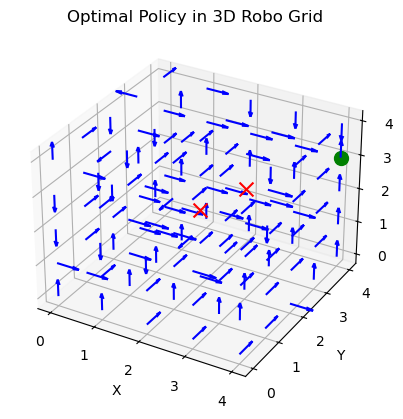

In [80]:
# Plot the optimal policy
plot_optimal_policy_3d(q_table, env)


Test policy

In [81]:
def test_policy(env, q_table):
    """Test the learned policy by navigating the grid and plot the path in 3D."""
    state = env.reset()
    done = False
    steps = 0
    path = [state]  # List to store the path taken

    while not done:
        # Always exploit the best learned policy (epsilon = 0.0)
        action = choose_action_3d(state, q_table, epsilon=0.0, actions=env.actions)
        next_state, reward, done = env.step(action)
        print(f"State: {state}, Action: {action}, Next State: {next_state}, Reward: {reward}")
        state = next_state
        path.append(next_state)  # Add next state to the path
        steps += 1
        if done:
            print(f"Reached goal in {steps} steps!")

    # Plot the path in 3D
    plot_path_3d(path, env)



In [82]:
def plot_path_3d(path, env):
    """Plot the 3D path taken by the robot during testing."""
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the path
    x_vals = [state[0] for state in path]
    y_vals = [state[1] for state in path]
    z_vals = [state[2] for state in path]
    ax.plot(x_vals, y_vals, z_vals, marker='o', color='b', label='Path')  # Path as a blue line

    # Mark the start state
    ax.scatter(path[0][0], path[0][1], path[0][2], color='m', s=100, label='Start', marker='o')

    # Plot goals
    for goal in env.goals:
        ax.scatter(goal[0], goal[1], goal[2], color='g', s=100, label='Goal', marker='o')

    # Plot obstacles
    for obstacle in env.obstacles:
        ax.scatter(obstacle[0], obstacle[1], obstacle[2], color='r', s=100, label='Obstacle', marker='x')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title('3D Path Taken by the Robot')

    # Only show one label for each type (Start, Goal, Obstacle)
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    ax.legend(unique_labels.values(), unique_labels.keys())

    plt.show()



Testing the learned policy with visualization:
State: (0, 0, 0), Action: up, Next State: (0, 0, 1), Reward: -0.01
State: (0, 0, 1), Action: forward, Next State: (1, 0, 1), Reward: -0.01
State: (1, 0, 1), Action: right, Next State: (1, 1, 1), Reward: -0.01
State: (1, 1, 1), Action: forward, Next State: (2, 1, 1), Reward: -0.01
State: (2, 1, 1), Action: right, Next State: (2, 2, 1), Reward: -0.01
State: (2, 2, 1), Action: right, Next State: (2, 3, 1), Reward: -0.01
State: (2, 3, 1), Action: right, Next State: (2, 4, 1), Reward: -0.01
State: (2, 4, 1), Action: forward, Next State: (3, 4, 1), Reward: -0.01
State: (3, 4, 1), Action: forward, Next State: (4, 4, 1), Reward: -0.01
State: (4, 4, 1), Action: up, Next State: (4, 4, 2), Reward: -0.01
State: (4, 4, 2), Action: up, Next State: (4, 4, 3), Reward: 1
Reached goal in 11 steps!


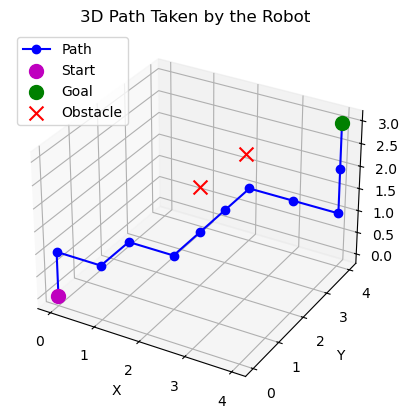

In [83]:
# Test the learned policy on the robo-grid and visualize the path
print("\nTesting the learned policy with visualization:")
test_policy(env, q_table)
